In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import pandas as pd


TABLE_FILE_NAME = 'table.csv'
NUM_FEATURES = (13, )
NUM_CLASSES = 5
LAYER_OUTPUT_WIDTH = 100

In [2]:
dataframe = pd.read_csv(TABLE_FILE_NAME)  # читаем .csv файл в DataFrame
dataframe.head()

,название карты,количество дружественных агентов,количество вражеских агентов,координата x дружественных агентов,координата y дружественных агентов,координата x вражеских агентов,координата y вражеских агентов,наличие препятствия,координата x начала стены,координата y начала стены,координата x середины стены,координата y середины стены,координата x конца стены,координата y конца стены,метка
0,2m2mFOX,2,2,1,1,10,1,0,2,2,4,2,8,2,q-learning
1,corridor,6,24,2,4,7,4,0,0,0,0,0,0,0,qmix
2,3s_vs_3z,3,4,1,1,20,20,1,1,7,6,4,11,1,facmaddpg
3,3s_vs_4z,3,4,1,3,9,3,1,6,3,6,7,6,9,qmix
4,3s5z_vs_3s6z,8,9,1,4,11,3,1,8,20,8,10,8,5,facmaddpg


In [3]:
def label_to_code(label):
    result = None
    if label == 'q-learning':
        result = 0
    elif label == 'qmix':
        result = 1
    elif label == 'facmaddpg':
        result = 2
    elif label == 'dop':
        result = 3
    elif label == 'dqn':
        result = 4
    return result

dataframe['метка'] = dataframe['метка'].apply(label_to_code)
dataframe

,название карты,количество дружественных агентов,количество вражеских агентов,координата x дружественных агентов,координата y дружественных агентов,координата x вражеских агентов,координата y вражеских агентов,наличие препятствия,координата x начала стены,координата y начала стены,координата x середины стены,координата y середины стены,координата x конца стены,координата y конца стены,метка
0,2m2mFOX,2,2,1,1,10,1,0,2,2,4,2,8,2,0
1,corridor,6,24,2,4,7,4,0,0,0,0,0,0,0,1
2,3s_vs_3z,3,4,1,1,20,20,1,1,7,6,4,11,1,2
3,3s_vs_4z,3,4,1,3,9,3,1,6,3,6,7,6,9,1
4,3s5z_vs_3s6z,8,9,1,4,11,3,1,8,20,8,10,8,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2m_vs_2zg,2,2,7,20,7,5,1,10,6,6,7,4,9,1
118,7m_vs_6m,7,6,5,14,12,6,1,2,2,4,2,9,2,4
119,8m_vs_4m,8,4,7,7,6,6,0,0,0,0,0,0,0,2
120,10m_vs_12m,10,12,5,10,9,3,1,13,5,7,7,2,9,3


In [4]:
DATASET_SIZE, _ = dataframe.shape
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
train_size = DATASET_SIZE - val_size - test_size

print('Обучающих точек данных: {}'.format(train_size))
print('Валидационных точек данных: {}'.format(val_size))
print('Тестовых точек данных: {}'.format(test_size))


def dataframe_to_dataset(dataframe):
    """Читает из датафрейма только точки данных и переводит в dataset."""
    dataframe = dataframe.copy()  # копируем входной DataFrame
    dataframe.pop('название карты')  # отбрасываем столбец с названиями карт
    labels = dataframe.pop('метка')  # вытаскиваем из DataFrame метки
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))  # создаём dataset
    return dataset


full_dataset = dataframe_to_dataset(dataframe)  # из DataFrame создаём Dataset
shuffled_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)  # перемешиваем
val_dataset = shuffled_dataset.take(val_size)  # выдёргиваем из всего датасета валидационную часть
tmp_dataset = shuffled_dataset.skip(val_size)  # оставляем часть от целого без валидационной
test_dataset = tmp_dataset.take(test_size)  # выдёргиваем из оставшейся части тестовую
train_dataset = tmp_dataset.skip(test_size)  # в обучающей части остаётся остальное

Обучающих точек данных: 98
Валидационных точек данных: 12
Тестовых точек данных: 12


In [5]:
for x, y in train_dataset.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'количество дружественных агентов': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'количество вражеских агентов': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'координата x дружественных агентов': <tf.Tensor: shape=(), dtype=int64, numpy=5>, 'координата y дружественных агентов': <tf.Tensor: shape=(), dtype=int64, numpy=10>, 'координата x вражеских агентов': <tf.Tensor: shape=(), dtype=int64, numpy=5>, 'координата y вражеских агентов': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'наличие препятствия': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата x начала стены': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата y начала стены': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата x середины стены': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата y середины стены': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата x конца стены': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'координата y конца стены': <tf.Tensor: shape=(), dtype=int64, numpy

In [6]:
train_dataset = train_dataset.batch(1)
val_dataset = val_dataset.batch(1)
test_dataset = test_dataset.batch(1)

In [7]:
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras


def encode_numerical_feature(feature, name, dataset):
    """."""
    normalizer = Normalization()  # Create a Normalization layer for our feature

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)  # Learn the statistics of the data

    encoded_feature = normalizer(feature)  # Normalize the input feature
    return encoded_feature


def encode_categorical_feature(feature, name, dataset):
    """."""
    lookup = IntegerLookup(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)  # Learn the set of possible string values and assign them a fixed integer index

    encoded_feature = lookup(feature)  # Turn the string input into integer indices
    return encoded_feature


n_friends = keras.Input(shape=(1,), name="количество дружественных агентов")
n_enemies = keras.Input(shape=(1,), name="количество вражеских агентов")
x_friends_coord = keras.Input(shape=(1,), name="координата x дружественных агентов")
y_friends_coord = keras.Input(shape=(1,), name="координата y дружественных агентов")
x_enemies_coord = keras.Input(shape=(1,), name="координата x вражеских агентов")
y_enemies_coord = keras.Input(shape=(1,), name="координата y вражеских агентов")
wall_exist = keras.Input(shape=(1,), name="наличие препятствия", dtype="int64")
x_wall_begins = keras.Input(shape=(1,), name="координата x начала стены")
y_wall_begins = keras.Input(shape=(1,), name="координата y начала стены")
x_wall_middle = keras.Input(shape=(1,), name="координата x середины стены")
y_wall_middle = keras.Input(shape=(1,), name="координата y середины стены")
x_wall_ends = keras.Input(shape=(1,), name="координата x конца стены")
y_wall_ends = keras.Input(shape=(1,), name="координата y конца стены")

all_inputs = [
    n_friends,
    n_enemies,
    x_friends_coord,
    y_friends_coord,
    x_enemies_coord,
    y_enemies_coord,
    wall_exist,
    x_wall_begins,
    y_wall_begins,
    x_wall_middle,
    y_wall_middle,
    x_wall_ends,
    y_wall_ends
]

n_friends_encoded = encode_numerical_feature(n_friends, "количество дружественных агентов", train_dataset)
n_enemies_encoded = encode_numerical_feature(n_enemies, "количество вражеских агентов", train_dataset)
x_friends_coord_encoded = encode_numerical_feature(x_friends_coord, "координата x дружественных агентов", train_dataset)
y_friends_coord_encoded = encode_numerical_feature(y_friends_coord, "координата y дружественных агентов", train_dataset)
x_enemies_coord_encoded = encode_numerical_feature(x_enemies_coord, "координата x вражеских агентов", train_dataset)
y_enemies_coord_encoded = encode_numerical_feature(y_enemies_coord, "координата y вражеских агентов", train_dataset)
wall_exist_encoded = encode_categorical_feature(wall_exist, "наличие препятствия", train_dataset)
x_wall_begins_encoded = encode_numerical_feature(x_wall_begins, "координата x начала стены", train_dataset)
y_wall_begins_encoded = encode_numerical_feature(y_wall_begins, "координата y начала стены", train_dataset)
x_wall_middle_encoded = encode_numerical_feature(x_wall_middle, "координата x середины стены", train_dataset)
y_wall_middle_encoded = encode_numerical_feature(y_wall_middle, "координата y середины стены", train_dataset)
x_wall_ends_encoded = encode_numerical_feature(x_wall_ends, "координата x конца стены", train_dataset)
y_wall_ends_encoded = encode_numerical_feature(y_wall_ends, "координата y конца стены", train_dataset)

all_features = layers.concatenate(
    [
        n_friends_encoded,
        n_enemies_encoded,
        x_friends_coord_encoded,
        y_friends_coord_encoded,
        x_enemies_coord_encoded,
        y_enemies_coord_encoded,
        wall_exist_encoded,
        x_wall_begins_encoded,
        y_wall_begins_encoded,
        x_wall_middle_encoded,
        y_wall_middle_encoded,
        x_wall_ends_encoded,
        y_wall_ends_encoded
    ]
)

In [8]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
количество дружественных агенто [(None, 1)]          0                                            
__________________________________________________________________________________________________
количество вражеских агентов (I [(None, 1)]          0                                            
__________________________________________________________________________________________________
координата x дружественных аген [(None, 1)]          0                                            
__________________________________________________________________________________________________
координата y дружественных аген [(None, 1)]          0                                            
______________________________________________________________________________________________

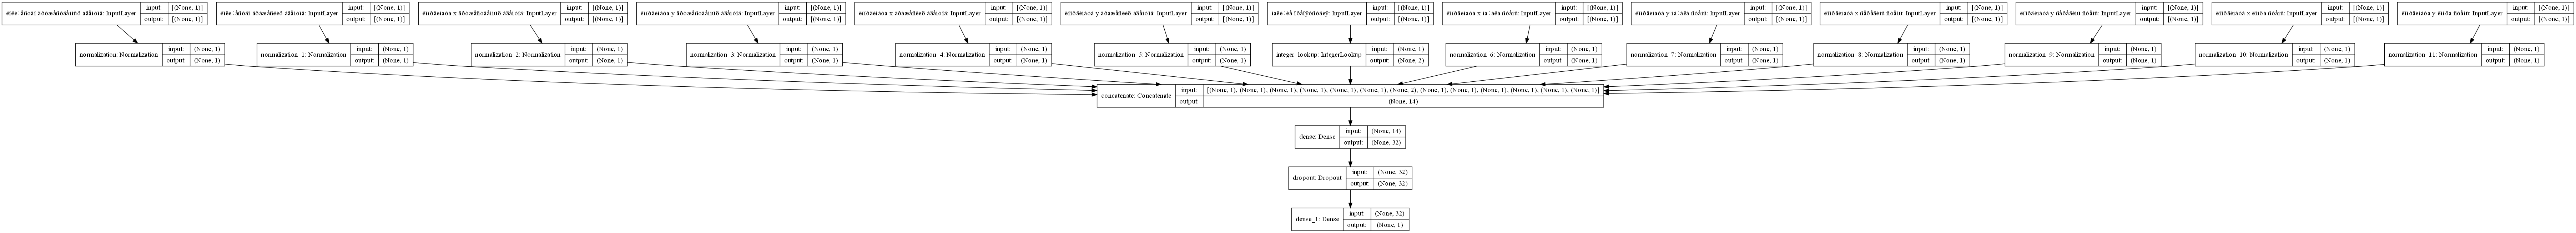

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, rankdir="TB", dpi=100)

In [11]:
model.fit(train_dataset, epochs=500, validation_data=val_dataset)

Epoch 1/500
98/98 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.2551 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 2/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2245 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 3/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2551 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 4/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2755 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 5/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3061 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 6/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2755 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 7/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2755 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 56/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 57/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 58/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 59/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 60/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 61/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_los

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 110/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3878 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 111/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3061 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 112/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 113/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 114/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.0833
Epoch 115/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.5833
Epoch 164/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 165/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.5833
Epoch 166/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 167/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 168/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.0833
Epoch 169/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 218/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.7500
Epoch 219/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 220/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3265 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 221/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 222/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2857 - val_loss: 0.0000e+00 - val_accuracy: 0.0833
Epoch 223/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3265 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 272/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 273/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 274/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2857 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 275/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 276/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.0833
Epoch 277/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 326/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 327/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 328/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 329/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 330/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3061 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 331/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3061 - v

98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 380/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 381/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 382/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3980 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 383/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3878 - val_loss: 0.0000e+00 - val_accuracy: 0.3333
Epoch 384/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.5833
Epoch 385/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - v

98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 434/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3878 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 435/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3265 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 436/500
98/98 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 437/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3571 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 438/500
98/98 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3788 - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 439/500
98/98 [==============================] - 0s 1m

98/98 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 488/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - val_loss: 0.0000e+00 - val_accuracy: 0.1667
Epoch 489/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 490/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3469 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 491/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3367 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 492/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3673 - val_loss: 0.0000e+00 - val_accuracy: 0.2500
Epoch 493/500
98/98 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3776 - v

In [12]:
model.evaluate(test_dataset)

12/12 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3333


[0.0, 0.3333333432674408]

In [13]:
sample = {
    'количество дружественных агентов': 4,
    'количество вражеских агентов': 4,
    'координата x дружественных агентов': 3,
    'координата y дружественных агентов': 3,
    'координата x вражеских агентов': 15,
    'координата y вражеских агентов': 15,
    'наличие препятствия': 1,
    'координата x начала стены': 1,
    'координата y начала стены': 1,
    'координата x середины стены': 3,
    'координата y середины стены': 2,
    'координата x конца стены': 5,
    'координата y конца стены': 5
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predict = model.predict(input_dict)


def predict_to_label(predict):
    label = None
    if int(predict[0][0]) == 0:
        label = 'q-learning'
    elif int(predict[0][0]) == 1:
        label = 'qmix'
    elif int(predict[0][0]) == 2:
        label = 'facmaddpg'
    elif int(predict[0][0]) == 3:
        label = 'dop'
    elif int(predict[0][0]) == 4:
        label = 'dqn'
    return label

print(predict_to_label(predict))

qmix
